# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [1]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [15]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def reset(self):
        """Resets the environment to a random starting state"""
        self.__init__()
        return self.current_location

    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [3]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [4]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        #type your code here
        # get current state from environment (adjust attribute name if different)
        state = getattr(self.environment, "agent_position", None)
        if state is None:
            state = getattr(self.environment, "agent_pos", None)
        if state is None:
            raise ValueError("Environment must expose current state as 'agent_position' or 'agent_pos'.")

        # explore
        if np.random.rand() < self.epsilon:
            return random.choice(available_actions)

        # exploit
        q_at_state = self.q_table[state]
        max_q = max(q_at_state[a] for a in available_actions)
        best_actions = [a for a in available_actions if q_at_state[a] == max_q]
        return random.choice(best_actions)

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
       #typr your code here
        q_sa = self.q_table[old_state][action]

        if new_state in self.q_table:                 # if terminal not in table, treat as 0
            next_max = max(self.q_table[new_state].values())
        else:
            next_max = 0.0

        target = reward + self.gamma * next_max
        self.q_table[old_state][action] = q_sa + self.alpha * (target - q_sa)


In [5]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [6]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 1)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = (4, 2)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

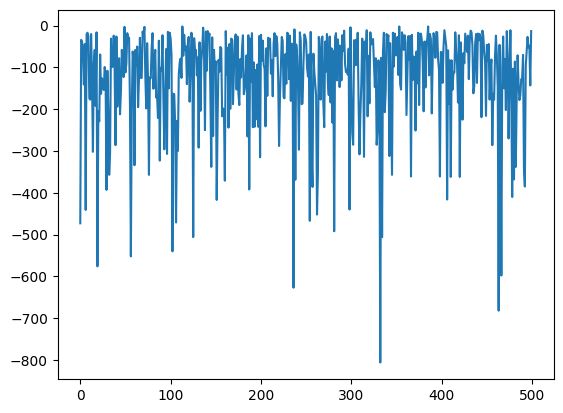

In [7]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

In [8]:
import numpy as np
import random

class Q_Agent:
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1.0):
        self.environment = environment
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        # Q-table init
        self.q_table = {}
        for x in range(environment.height):
            for y in range(environment.width):
                self.q_table[(x, y)] = {'UP':0.0, 'DOWN':0.0, 'LEFT':0.0, 'RIGHT':0.0}

    def _get_state_from_env(self):
        # Access the agent's current location directly from the environment
        return self.environment.current_location

    def choose_action(self, available_actions):
        state = self._get_state_from_env()
        if np.random.rand() < self.epsilon:          # explore
            return random.choice(available_actions)
        q = self.q_table[state]                       # exploit
        m = max(q[a] for a in available_actions)
        best = [a for a in available_actions if q[a] == m]
        return random.choice(best)

    def learn(self, old_state, reward, new_state, action):
        q_sa = self.q_table[old_state][action]
        next_max = max(self.q_table[new_state].values()) if new_state in self.q_table else 0.0
        target = reward + self.gamma * next_max
        self.q_table[old_state][action] = q_sa + self.alpha * (target - q_sa)

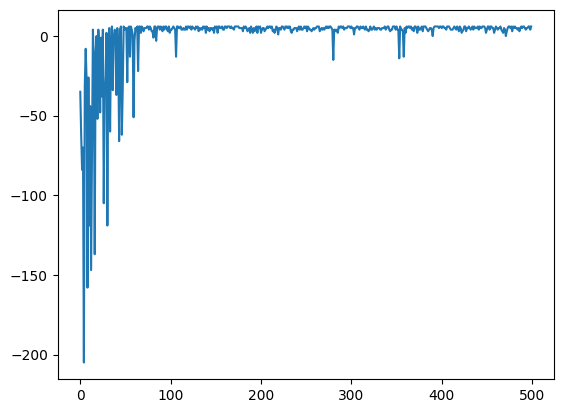

In [9]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

Print the final Q-value table with nice formatting.

In [10]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.4
	DOWN
		-0.44001755040000007
	LEFT
		-0.4
	RIGHT
		-0.34714900000000004
(0, 1)
	UP
		-0.2
	DOWN
		-0.2
	LEFT
		-0.20900000000000002
	RIGHT
		3.990419111666131
(0, 2)
	UP
		4.839807874885971
	DOWN
		3.207166769044112
	LEFT
		0.45911473751936777
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0.0
	DOWN
		0.0
	LEFT
		0.0
	RIGHT
		0.0
(0, 4)
	UP
		0.8953616023134119
	DOWN
		0.23757261047925746
	LEFT
		9.999924982764238
	RIGHT
		0.1821585644165966
(0, 5)
	UP
		-0.1
	DOWN
		-0.2
	LEFT
		3.2892485778684817
	RIGHT
		-0.11000000000000001
(0, 6)
	UP
		-0.30000000000000004
	DOWN
		-0.31000000000000005
	LEFT
		-0.189251185609
	RIGHT
		-0.32699999999999996
(0, 7)
	UP
		-0.399
	DOWN
		-0.43339000000000005
	LEFT
		-0.46313500700000004
	RIGHT
		-0.4
(1, 0)
	UP
		-0.55471
	DOWN
		-0.564929
	LEFT
		-0.6
	RIGHT
		-0.48675258642581365
(1, 1)
	UP
		-0.28485275828329004
	DOWN
		-0.30900000000000005
	LEFT
		-0.30900000000000005
	RIGHT
		3.2851297986053316
(1, 2)
	UP
		8.999999999999986
	DOWN
		1.24

In [11]:
display(agentQ.q_table)

{(0, 0): {'UP': np.float64(-0.4),
  'DOWN': np.float64(-0.44001755040000007),
  'LEFT': np.float64(-0.4),
  'RIGHT': np.float64(-0.34714900000000004)},
 (0, 1): {'UP': np.float64(-0.2),
  'DOWN': np.float64(-0.2),
  'LEFT': np.float64(-0.20900000000000002),
  'RIGHT': np.float64(3.990419111666131)},
 (0, 2): {'UP': np.float64(4.839807874885971),
  'DOWN': np.float64(3.207166769044112),
  'LEFT': np.float64(0.45911473751936777),
  'RIGHT': np.float64(9.999999999999993)},
 (0, 3): {'UP': 0.0, 'DOWN': 0.0, 'LEFT': 0.0, 'RIGHT': 0.0},
 (0, 4): {'UP': np.float64(0.8953616023134119),
  'DOWN': np.float64(0.23757261047925746),
  'LEFT': np.float64(9.999924982764238),
  'RIGHT': np.float64(0.1821585644165966)},
 (0, 5): {'UP': np.float64(-0.1),
  'DOWN': np.float64(-0.2),
  'LEFT': np.float64(3.2892485778684817),
  'RIGHT': np.float64(-0.11000000000000001)},
 (0, 6): {'UP': np.float64(-0.30000000000000004),
  'DOWN': np.float64(-0.31000000000000005),
  'LEFT': np.float64(-0.189251185609),
  'R

# Lab 7 Part 2

## Question 1

In [16]:
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import random, matplotlib.pyplot as plt

# --- sizes ---
def get_n_states(env):   return int(env.height * env.width)
def get_n_actions(env):  return int(len(env.actions))

# --- (row,col) <-> index ---
def s_to_idx(s, env):
    x, y = s
    return int(x * env.width + y)

def idx_to_s(idx, env):
    x = idx // env.width
    y = idx % env.width
    return (int(x), int(y))

def one_hot(idx, n):
    v = np.zeros(n, dtype=np.float32); v[idx] = 1.0
    return v

# --- reset/step wrappers ---
def reset_env(env):
    s = env.reset()          # returns (x,y)
    return s_to_idx(s, env)  # return index

def step_env(env, a_idx):
    a_str = env.actions[a_idx]   # map index -> 'UP'/'DOWN'...
    r = env.make_step(a_str)     # updates env.current_location
    ns = env.current_location
    done = (env.check_state() == 'TERMINAL')
    return s_to_idx(ns, env), r, done, {}

In [13]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    def forward(self, x):
        if isinstance(x, np.ndarray): x = torch.tensor(x, dtype=torch.float32)
        if x.ndim == 1: x = x.unsqueeze(0)
        return self.net(x)

def select_action(qnet, s_idx, epsilon, action_dim, n_states):
    if random.random() < epsilon:
        return random.randrange(action_dim)
    with torch.no_grad():
        q = qnet(one_hot(s_idx, n_states))
        return int(q.argmax(1).item())

def td_update(qnet, opt, s_idx, a, r, ns_idx, done, gamma, n_states):
    q_sa = qnet(one_hot(s_idx, n_states)).gather(1, torch.tensor([[a]])).squeeze(1)
    with torch.no_grad():
        max_next = qnet(one_hot(ns_idx, n_states)).max(1).values
        y = torch.tensor([r], dtype=torch.float32) if done else torch.tensor([r], dtype=torch.float32) + gamma*max_next
    loss = nn.MSELoss()(q_sa, y)
    opt.zero_grad(); loss.backward(); opt.step()
    return float(loss.item())

def train_dqn_gridworld(env, episodes, epsilon, alpha=1e-3, gamma=0.99, max_steps=10_000):
    nS, nA = get_n_states(env), get_n_actions(env)
    qnet = DQN(nS, nA)
    opt  = optim.Adam(qnet.parameters(), lr=alpha)

    rewards, losses = [], []
    for ep in range(episodes):
        s = reset_env(env)              # index state
        done, ep_r, ep_loss, steps = False, 0.0, [], 0
        while not done and steps < max_steps:
            a = select_action(qnet, s, epsilon, nA, nS)
            ns, r, done, _ = step_env(env, a)
            loss = td_update(qnet, opt, s, a, r, ns, done, gamma, nS)
            ep_loss.append(loss)
            s = ns; ep_r += r; steps += 1
        rewards.append(ep_r)
        losses.append(np.mean(ep_loss) if ep_loss else 0.0)
    return qnet, rewards, losses

def moving_avg(x, k=25):
    x = np.asarray(x, float)
    if len(x) < k: return x
    return np.convolve(x, np.ones(k)/k, mode='valid')

In [17]:
# Create your env (class cell MUST be run already)
env = GridWorld()

episodes  = 600
epsilons  = [0.1, 0.5, 0.9]
results = {}

for eps in epsilons:
    _, rewards, _ = train_dqn_gridworld(env, episodes, epsilon=eps, alpha=1e-3, gamma=0.99)
    results[eps] = rewards

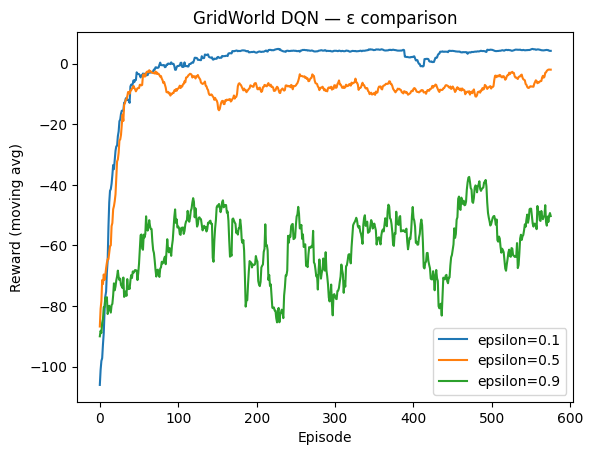

In [18]:
plt.figure()
for eps in epsilons:
    plt.plot(moving_avg(results[eps], 25), label=f"epsilon={eps}")
plt.xlabel("Episode"); plt.ylabel("Reward (moving avg)")
plt.title("GridWorld DQN — ε comparison")
plt.legend(); plt.show()

## Question 2

In [19]:
for eps in epsilons:
    r = results[eps]
    print(f"epsilon={eps}: last-50 avg reward = {np.mean(r[-50:]):.2f}")

epsilon=0.1: last-50 avg reward = 4.46
epsilon=0.5: last-50 avg reward = -4.76
epsilon=0.9: last-50 avg reward = -49.10


In [20]:
# 1) System packages needed to build box2d-py
!apt-get -y update
!apt-get -y install swig cmake

# 2) Clean conflicting packages (if any)
!pip -q uninstall -y Box2D box2d

# 3) Install the exact versions the lab expects
!pip -q install gym==0.26.2 box2d-py==2.3.8

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,322 kB]
Get:13 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,06

In [21]:
import gym, Box2D
env = gym.make("LunarLander-v2")
obs = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
print("OK -> state_dim:", env.observation_space.shape[0], " action_dim:", env.action_space.n)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


OK -> state_dim: 8  action_dim: 4


In [22]:
import math, random, collections, numpy as np
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
import gym

# make env
env = gym.make("LunarLander-v2")   # needs box2d-py
state_dim  = env.observation_space.shape[0]   # 8
action_dim = env.action_space.n               # 4

def reset_env(env):
    out = env.reset()
    return out[0] if isinstance(out, tuple) else out

def step_env(env, a):
    out = env.step(a)
    if len(out) == 5:  # (s', r, terminated, truncated, info)
        ns, r, term, trunc, info = out
        return ns, r, bool(term or trunc), info
    return out

In [23]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, action_dim)
        )
    def forward(self, x):
        if isinstance(x, np.ndarray): x = torch.tensor(x, dtype=torch.float32)
        if x.ndim == 1: x = x.unsqueeze(0)
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buf = collections.deque(maxlen=capacity)
    def push(self, s,a,r,ns,d):
        self.buf.append((s,a,r,ns,d))
    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s,a,r,ns,d = map(np.array, zip(*batch))
        return (torch.tensor(s,  dtype=torch.float32),
                torch.tensor(a,  dtype=torch.int64),
                torch.tensor(r,  dtype=torch.float32),
                torch.tensor(ns, dtype=torch.float32),
                torch.tensor(d,  dtype=torch.float32))
    def __len__(self): return len(self.buf)

# epsilon schedule (linear decay)
def epsilon_by_episode(ep, start=1.0, end=0.05, decay_episodes=800):
    t = min(1.0, ep/decay_episodes)
    return start + (end - start) * t

In [24]:
@torch.no_grad()
def select_action(q_online, state, epsilon, action_dim):
    if random.random() < epsilon:
        return random.randrange(action_dim)
    return int(q_online(state).argmax(1).item())

def dqn_update(q_online, q_target, opt, replay, batch_size=64, gamma=0.99):
    if len(replay) < batch_size: return None
    s,a,r,ns,d = replay.sample(batch_size)

    # Q(s,a)
    q_sa = q_online(s).gather(1, a.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        max_next = q_target(ns).max(1).values
        y = r + (1 - d) * gamma * max_next

    loss = nn.MSELoss()(q_sa, y)
    opt.zero_grad(); loss.backward(); opt.step()
    return float(loss.item())

In [25]:
def train_lander(use_replay=True, use_target=True,
                 episodes=800, gamma=0.99, lr=1e-3,
                 target_update_every=1000, batch_size=64,
                 buffer_cap=100_000, warmup=2000, max_steps=2000):

    q_online = DQN(state_dim, action_dim)
    q_target = DQN(state_dim, action_dim)
    q_target.load_state_dict(q_online.state_dict())
    opt = optim.Adam(q_online.parameters(), lr=lr)

    replay = ReplayBuffer(buffer_cap)
    global_steps = 0

    rewards, epsilons, losses = [], [], []

    for ep in range(episodes):
        s = reset_env(env)
        done, ep_r = False, 0.0
        epsilon = epsilon_by_episode(ep)
        steps = 0

        while not done and steps < max_steps:
            a = select_action(q_online, s, epsilon, action_dim)
            ns, r, done, _ = step_env(env, a)

            if use_replay:
                replay.push(s,a,r,ns, float(done))
                loss = dqn_update(q_online, (q_target if use_target else q_online),
                                  opt, replay, batch_size, gamma) if global_steps > warmup else None
            else:
                # on-line TD(0) without replay/target (ablation)
                s_t  = torch.tensor(s,  dtype=torch.float32).unsqueeze(0)
                ns_t = torch.tensor(ns, dtype=torch.float32).unsqueeze(0)
                a_t  = torch.tensor([a])
                r_t  = torch.tensor([r], dtype=torch.float32)
                q_sa = q_online(s_t).gather(1, a_t.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    max_next = q_online(ns_t).max(1).values
                    y = r_t if done else r_t + gamma * max_next
                loss = nn.MSELoss()(q_sa, y)
                opt.zero_grad(); loss.backward(); opt.step()

            if loss is not None: losses.append(loss)

            s = ns; ep_r += r; steps += 1; global_steps += 1

            # hard update target net
            if use_target and (global_steps % target_update_every == 0):
                q_target.load_state_dict(q_online.state_dict())

        rewards.append(ep_r); epsilons.append(epsilon)

    return {"rewards": rewards,
            "epsilons": epsilons,
            "losses": [l.item() if hasattr(l, "item") else float(l) for l in losses]}


In [26]:
import numpy as np
# NumPy 2.0 compatibility shim:
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

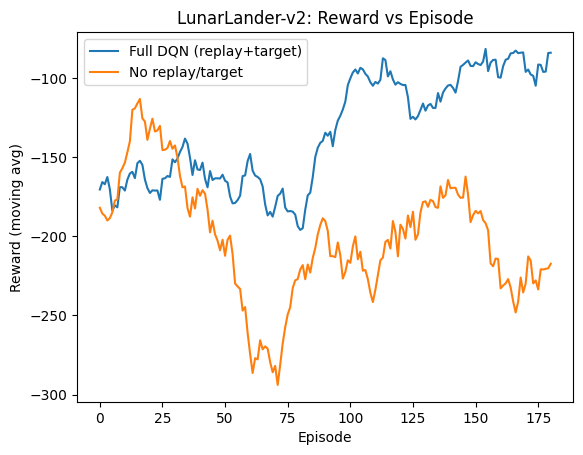

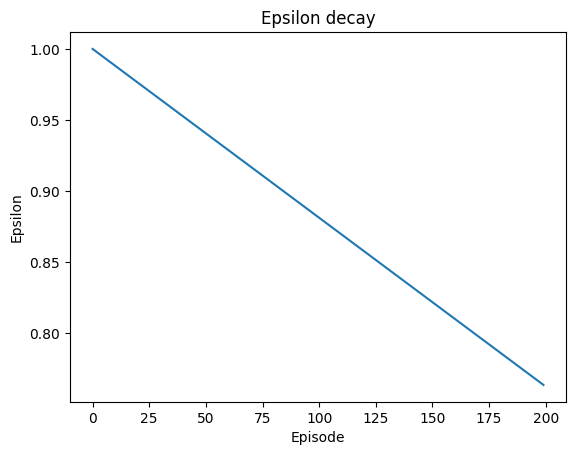

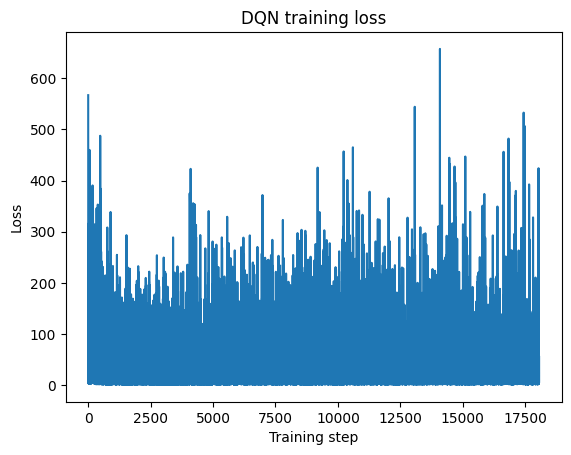

Full DQN  last-20 avg: -83.8
No replay last-20 avg: -217.3


In [27]:
def moving_avg(x, k=20):
    x = np.asarray(x, float)
    if len(x) < k: return x
    return np.convolve(x, np.ones(k)/k, mode='valid')

# Full DQN (replay + target)
full = train_lander(use_replay=True, use_target=True, episodes=200)

# Ablation: no replay, no target
abl  = train_lander(use_replay=False, use_target=False, episodes=200)

# --- Plots ---
plt.figure()
plt.plot(moving_avg(full["rewards"], 20), label="Full DQN (replay+target)")
plt.plot(moving_avg(abl["rewards"],  20), label="No replay/target")
plt.xlabel("Episode"); plt.ylabel("Reward (moving avg)")
plt.title("LunarLander-v2: Reward vs Episode")
plt.legend(); plt.show()

plt.figure()
plt.plot(full["epsilons"])
plt.xlabel("Episode"); plt.ylabel("Epsilon")
plt.title("Epsilon decay"); plt.show()

# (optional) loss
if len(full["losses"])>0:
    plt.figure()
    plt.plot(full["losses"])
    plt.xlabel("Training step"); plt.ylabel("Loss")
    plt.title("DQN training loss"); plt.show()

# quick numbers for your Word doc
print("Full DQN  last-20 avg:", np.mean(full["rewards"][-20:]).round(1))
print("No replay last-20 avg:", np.mean(abl["rewards"][-20:]).round(1))
